In [1]:
# Import the dataset
from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

Using TensorFlow backend.


In [2]:
# Show an image
import matplotlib.pyplot as plt

plt.imshow(X_train[0], cmap = plt.cm.gray_r)
plt.plot()

[]

In [3]:
# Normalize the data
X_train = X_train/255
X_test = X_test/255

In [4]:
# Reshape the data
import numpy as np
n_pixels = np.prod(X_train.shape[1:])

X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

In [5]:
# Put labels to one hot vectors
from keras.utils import to_categorical

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

In [6]:
# define the encoder
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.layers.merge import concatenate as concat

n_pixels = 784
n_z = 2
n_classes = 10
m = 250

decoder_dim = 512
encoder_dim = 512

# define the input layer: the pixel values
input_img = Input(shape=(n_pixels,))

# encode
encoder_h = Dense(encoder_dim, activation='relu')(input_img)

# compute the mu and sigma
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

# compute z
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

# merge latent space with labels
label = Input(shape=(n_classes,))
zc = concat([z, label])

# decode
decoder = Dense(decoder_dim, activation='relu')(zc)
outputs = Dense(n_pixels, activation='sigmoid')(decoder)

In [7]:
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [8]:
cvae = Model([input_img, label], outputs)
encoder = Model([input_img, label], mu)

d_in = Input(shape=(n_z+n_classes,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [9]:
# Compile
cvae.compile(optimizer='adam', loss=vae_loss, metrics = [KL_loss, recon_loss])

In [10]:
# fit
from keras.callbacks import EarlyStopping

cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=m, epochs=50,
                     validation_data = ([X_test, y_test], X_test),
                     callbacks = [EarlyStopping(patience = 10)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s 119us/step - loss: 200.3609 - KL_loss: 9.1868 - recon_loss: 191.1741 - val_loss: 157.9052 - val_KL_loss: 4.3665 - val_recon_loss: 153.5387
Epoch 2/50
60000/60000 [==============================] - 8s 138us/step - loss: 151.7707 - KL_loss: 4.1811 - recon_loss: 147.5897 - val_loss: 146.8410 - val_KL_loss: 4.0732 - val_recon_loss: 142.7678
Epoch 3/50
60000/60000 [==============================] - 8s 142us/step - loss: 144.8964 - KL_loss: 4.1518 - recon_loss: 140.7446 - val_loss: 143.2354 - val_KL_loss: 4.1412 - val_recon_loss: 139.0943
Epoch 4/50
60000/60000 [==============================] - 9s 142us/step - loss: 142.0057 - KL_loss: 4.1889 - recon_loss: 137.8168 - val_loss: 140.9403 - val_KL_loss: 4.1122 - val_recon_loss: 136.8280
Epoch 5/50
60000/60000 [==============================] - 9s 142us/step - loss: 140.3158 - KL_loss: 4.2195 - recon_loss: 136.0963 - val_loss: 139.6434

60000/60000 [==============================] - 9s 148us/step - loss: 130.9336 - KL_loss: 4.6981 - recon_loss: 126.2355 - val_loss: 132.9109 - val_KL_loss: 4.5881 - val_recon_loss: 128.3228
Epoch 42/50
60000/60000 [==============================] - 9s 143us/step - loss: 130.8695 - KL_loss: 4.7005 - recon_loss: 126.1690 - val_loss: 132.8864 - val_KL_loss: 4.6783 - val_recon_loss: 128.2081
Epoch 43/50
60000/60000 [==============================] - 9s 144us/step - loss: 130.7810 - KL_loss: 4.7073 - recon_loss: 126.0737 - val_loss: 132.8712 - val_KL_loss: 4.6814 - val_recon_loss: 128.1899
Epoch 44/50
60000/60000 [==============================] - 9s 148us/step - loss: 130.7063 - KL_loss: 4.7061 - recon_loss: 126.0002 - val_loss: 132.9620 - val_KL_loss: 4.7263 - val_recon_loss: 128.2357
Epoch 45/50
60000/60000 [==============================] - 9s 144us/step - loss: 130.6264 - KL_loss: 4.7172 - recon_loss: 125.9092 - val_loss: 132.7957 - val_KL_loss: 4.5996 - val_recon_loss: 128.1962
Epoch 4

In [11]:
encoded_X0 = encoder.predict([X_train[0].reshape((1, 784)), y_train[0].reshape((1, 10))])
print(encoded_X0)

[[0.0483121  0.29037896]]


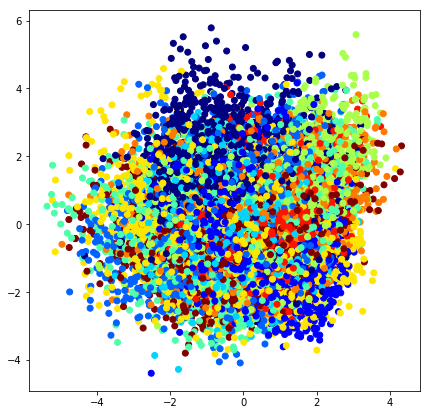

In [12]:
z_train = encoder.predict([X_train, y_train])
encodings= np.asarray(z_train)
encodings = encodings.reshape(X_train.shape[0], n_z)
plt.figure(figsize=(7, 7))
plt.scatter(encodings[:, 0], encodings[:, 1], c=Y_train, cmap=plt.cm.jet)
plt.show()

In [13]:
def construct_numvec(digit, z = None):
    out = np.zeros((1, n_z + n_classes))
    out[:, digit + n_z] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)
    
sample_3 = construct_numvec(3)
print(sample_3)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


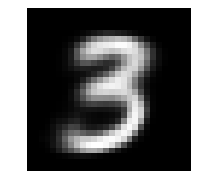

In [14]:
plt.figure(figsize=(3, 3))
plt.imshow(decoder.predict(sample_3).reshape(28,28), cmap = plt.cm.gray)
plt.axis('off')
plt.show()

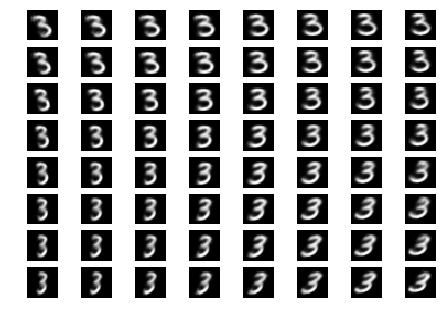

In [15]:
dig = 3
sides = 8
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        plt.subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray)
        plt.axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()

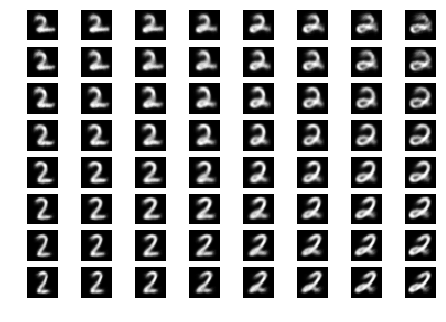

In [16]:
dig = 2
sides = 8
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        plt.subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray)
        plt.axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()